# Second Experiment
In this experiment, we want to investigate, the PDD network can improove the performance, when using a knowledge compression method. The teacher will be the FlowNet2 with pretrained weights, which can be found [here](https://drive.google.com/drive/folders/0B5EC7HMbyk3CbjFPb0RuODI3NmM?resourcekey=0-SuPU4qVZzuB4s83ngjrAEg). 

As there are multiple different way in applying the loss function, when using knowledge compression, there will be three different loss functions compared here. 
1) In a standard knowledge compression, the KL divergence is used to approximate the teacher output. We will compare the different warped labels of student and teacher. However, as this is usually done in classificatin, we do not expect it to perform really well in this setting.

2) A different approach is to use the MSE between the estimated flow field of the teacher and the estimated flowfield of the student. This does, however, not incorporate the warped label and dice score. The MSE is expressed as: $$L =\sum_{i,j}(prediction[i,j] - target[i,j])^2 $$ where $[i,j]$ denotes the flowfield at position i,j. 

3) What is missing in 2) will be used in the last setting. We incorporate the loss of the warped label. This can happen either by simply adding the loss to the loss between the flow fields OR by using a scale factor (probably dice score of the teacher) which indicates how well the teacher performs on this specific example. The loss can then be expressed as follows: $$L_i = \delta * L_{flowfield} + (1-\delta) * L_{Label}$$ With $\delta$ being the dice score between warped teacher segment and fixed segmentation. $L_i$ is the loss ofr the $i_{th}$ example, $L_{flowfield}$ is the crossentropy loss between student and teacher flow estimation and $L_{Label}$ is the warping loss between student warped segmentation and the segmentation to approximate.


Evantually only the results using PWC-Net and Flownet2 as teachers were used in the thesis. The text above was the plan, when the thesis started.

In [1]:
import numpy as np
import cv2
from PIL import Image
import os
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import pandas as pd
import datetime as datetime
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp
from utils.encoding import labelMatrixOneHot, dice_coeff

from models.pdd_net.pdd_student import OBELISK2d

# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7f1fb7e700d0>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

In [2]:
mode = 'Knowledge Compression'
def update_sheet(epochs, optim, loss_str ,grad_accum,lr, mode, eval_mean_dice, unwarped_dice, notes=""):
    """
    function to update a csv table to keep track of results
    """
    df = pd.read_csv('experiments.csv')
    df = df.drop(['Unnamed: 0'], axis=1)
    df = df.append({
        'epochs':epochs,
        'optim':optim,
        'batch size': grad_accum,
        'learning rate': lr,
        'loss':loss,
        'mode': mode,
        'Eval mean dice': eval_mean_dice,
        'unwarped dice': unwarped_dice,
        'time': datetime.datetime.now().strftime("%d.%m.%y %H:%M"),
        'notes': notes
    }, ignore_index=True)
    df.to_csv('experiments.csv')
    print('updated')

# Data

In [3]:
imgs2 = torch.load('/share/data_ultraschall/nicke_ma/data/train_frames_disp_6.pth')
segs2 = torch.load('/share/data_ultraschall/nicke_ma/data/train_segs_disp_6.pth')

imgs3 = torch.load('/share/data_ultraschall/nicke_ma/data/frames_oneFixed_multipleMoving.pth')
segs3 = torch.load('/share/data_ultraschall/nicke_ma/data/segs_oneFixed_multipleMoving.pth')

imgs = torch.cat((imgs2,imgs3))
segs = torch.cat((segs2,segs3))

#define a training split 
torch.manual_seed(42)
# Now, we prepare our train & test dataset.
train_set = torch.from_numpy(np.random.choice(np.arange(len(imgs)),size=int(len(imgs)*0.95), replace=False))

test_set = torch.arange(len(imgs))
for idx in train_set:
    test_set = test_set[test_set != idx]


print(f"{train_set.shape[0]} train examples")
print(f"{test_set.shape[0]} test examples")

3020 train examples
159 test examples


# Student

In [4]:
class OBELISK2d(nn.Module):
    def __init__(self, chan=16, size=(150,150)):
        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2, channels * 2, 2) * 0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels * 8, channels * 4, 1, bias=False,
                                groups=1)
        self.batch1 = nn.BatchNorm2d(channels * 4)
        self.layer2 = nn.Conv2d(channels * 4, channels * 4, 3, bias=False,
                                padding=1)
        self.batch2 = nn.BatchNorm2d(channels * 4)
        self.layer3 = nn.Conv2d(channels * 4, channels * 1, 1)

        H = size[0]
        W = size[1]
        self.o_m = H // 4 +1
        self.o_n = W // 4 +1

        self.displace_range = 11
        self.disp_hw = 5
        self.ogrid_xy = F.affine_grid(torch.eye(2, 3).unsqueeze(0),
                                 (1, 1, self.o_m, self.o_n)).view(1, 1, -1, 2).cuda()
        self.disp_range = 0.25
        self.displacement_width = 11
        shift_xy = F.affine_grid(self.disp_range * torch.eye(2, 3).unsqueeze(0), (1, 1, self.displacement_width, self.displacement_width)).view(1, 1, -1, 2).cuda()
        grid_size = 32  # 25#30
        self.grid_xy = F.affine_grid(torch.eye(2, 3).unsqueeze(0),
                                (1, 1, grid_size, grid_size)).view(1, -1, 1,
                                                                   2).cuda()

    def forward(self, fixed_img, moving_img):
        img_in_f = F.avg_pool2d(fixed_img, 3, padding=1, stride=2)
        img_in_f = F.relu(self.batch0(self.layer0(img_in_f)))
        sampled_f = F.grid_sample(img_in_f,self.ogrid_xy + self.offsets[0, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)
        sampled_f -= F.grid_sample(img_in_f,self.ogrid_xy + self.offsets[1, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)

        x_1 = F.relu(self.batch1(self.layer1(sampled_f)))
        x_1 = F.relu(self.batch2(self.layer2(x_1)))
        features_fixed = self.layer3(x_1)
        
        img_in_m = F.avg_pool2d(moving_img, 3, padding=1, stride=2)
        img_in_m = F.relu(self.batch0(self.layer0(img_in_m)))
        sampled_m = F.grid_sample(img_in_m,self.ogrid_xy + self.offsets[0, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)
        sampled_m -= F.grid_sample(img_in_m,self.ogrid_xy + self.offsets[1, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)

        x_2 = F.relu(self.batch1(self.layer1(sampled_m)))
        x_2 = F.relu(self.batch2(self.layer2(x_2)))
        features_moving = self.layer3(x_2)

        ssd_distance = self.correlation_layer(features_moving, features_fixed)
        soft_cost,disp_xy = self.meanfield(ssd_distance, fixed_img, self.displace_range, self.o_m, self.o_n)
        
        return soft_cost, disp_xy


    def min_convolution(self, ssd_distance, displace_range, H, W):
        # Prepare operators for smooth dense displacement space
        pad1 = nn.ReplicationPad2d(5)
        avg1 = nn.AvgPool2d(5, stride=1)
        max1 = nn.MaxPool2d(3, stride=1)
        pad2 = nn.ReplicationPad2d(4)
        # approximate min convolution / displacement compatibility

        ssd_minconv = avg1(avg1(-max1(-pad1(
            ssd_distance.permute(0, 2, 3, 1).reshape(1, -1, self.displace_range,
                                                    self.displace_range)))))

        ssd_minconv = ssd_minconv.permute(0, 2, 3, 1).view(1, -1, H, W)
        min_conv_cost = avg1(avg1(pad2(ssd_minconv)))

        return min_conv_cost


    def meanfield(self, ssd_distance, img_fixed, displace_range, H, W):
        crnt_dev = ssd_distance.device

        cost = self.min_convolution(ssd_distance, displace_range, H, W)

        soft_cost = F.softmax(-10 * cost.view(displace_range ** 2, -1).t(), 1)

        disp_hw = (displace_range - 1) // 2
        disp_mesh_grid = disp_hw * F.affine_grid(torch.eye(2, 3).unsqueeze(0), (
        1, 1, displace_range, displace_range), align_corners=True)
        disp_mesh_grid /= torch.Tensor([(W - 1) * .5, (H - 1) * .5])

        disp_xy = torch.sum(
            soft_cost.view(1, H, W, -1, 1) * disp_mesh_grid.view(1, 1, 1, -1,
                                                                2).to(crnt_dev),
            3).permute(0, 3, 1, 2)

        return soft_cost, disp_xy


    def correlation_layer(self, feat_moving, feat_fixed):
        disp_hw = (self.displacement_width - 1) // 2
        feat_moving_unfold = F.unfold(feat_moving.transpose(1, 0),
                                    (self.displace_range, self.displace_range),
                                    padding=self.disp_hw)
        B, C, H, W = feat_fixed.size()

        ssd_distance = ((feat_moving_unfold - feat_fixed.view(C, 1, -1)) ** 2).sum(0).view(1, displace_range ** 2, H, W)

        return ssd_distance

# Teacher

In [5]:
flownet = load_flownet2().cuda()
flownet.eval()

FlowNet2(
  (flownetc): FlowNetC(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv_redir): Sequential(
      (0): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (corr_activation): LeakyReLU(negative_slope=0.1, inplace=True)
    (conv3_1): Sequential(
      (0): Conv2d(473, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), 

In [6]:
pwc = load_pwcnet().cuda()
pwc.eval()

PWCDCNet(
  (conv1a): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1aa): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1b): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2a): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2aa): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2b): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv3a): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)

# Experiment 2.1
Using soft labels of flownet

In [10]:
disp_hw = 5
displace_range = 11

epochs = 50
lr = 0.002
# minibatch training
grad_accum = 20

student = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(64),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(64,16,kernel_size=1,stride=1,padding=0,dilation=1),
                          torch.nn.Sigmoid())
init_weights(student)
student.train().cuda()

optimizer = torch.optim.Adam(list(student.parameters()),lr=lr)

In [ ]:
losses = []
accs = []
unwarped = []
scale=1
for epoch in tqdm(range(epochs)):

    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for i, rnd_idx in enumerate(rnd_train_idx):
        tmp_loss = []
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous() * 2
        moving_seg = segs[p_fix:p_fix+1,1,:].contiguous() * 2

        if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
            fixed_seg = fixed_seg*2
        if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
            moving_seg = moving_seg*2
        
        ########## FlowNet2
        # Here we have to rescale the images for the flownet
        # the flownet expects intputs that match x*64, when m and n < 200
        teacher_fixed = F.interpolate(fixed, size=(scale*64,scale*64), mode='bicubic')
        teacher_moving = F.interpolate(moving, size=(scale*64,scale*64), mode='bicubic')
        # Generate the teacher flow estimation
        flow_in = preprocessing_flownet(teacher_fixed.detach().clone().reshape(scale*64,scale*64,1),teacher_moving.detach().clone().reshape(scale*64,scale*64,1)).cuda() * 255
        flownet_flow = flownet(flow_in)
        flownet_flow = F.interpolate(flownet_flow.cpu(), size=(H,W), mode='bicubic')

        # warp segmentation with flownet flow
        warped_flownet_seg = warp(moving_seg.float().unsqueeze(0).cuda(), flownet_flow.cuda()).cpu()

        # Label preparation for PDD
        C1,Hf,Wf = moving_seg.size()
        label_moving_onehot = F.one_hot(moving_seg.long(),num_classes=3).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving_onehot,size=(Hf//4,Wf//4),mode='bicubic')
        label_fixed = F.one_hot(fixed_seg.long(),num_classes=3).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed,size=(Hf//4,Wf//4),mode='bicubic')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,3,displace_range**2,-1)

        with torch.cuda.amp.autocast():
            ########## PDD Forward pass
            feat00 = student(fixed.cuda())
            feat50 = student(moving.cuda())

            # compute the cost tensor using the correlation layer
            ssd_distance = correlation_layer(displace_range, feat50, feat00)

            # compute the MIN-convolution & probabilistic output with the given function
            soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)


            # warp the label
            label_warped = torch.sum(soft_cost.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)

            flownet_onehot_seg = F.one_hot(F.interpolate(warped_flownet_seg, size=(H//4,W//4)).long(),3)

            diff = torch.mean(torch.pow(label_warped-flownet_onehot_seg.view(label_warped.shape),2))
            label_distance1 = torch.sum(torch.pow(label_fixed.reshape(3,-1)-label_warped.reshape(3,-1),2),0)

            diffloss = 1.5*((disp_xy[0,:,1:,:]-disp_xy[0,:,:-1,:])**2).mean()+\
                1.5*((disp_xy[0,1:,:,:]-disp_xy[0,:-1,:,:])**2).mean()+\
                1.5*((disp_xy[0,:,:,1:]-disp_xy[0,:,:,:-1])**2).mean()

            loss = diff + diffloss #+ label_distance1.mean()
        loss.backward()
        tmp_loss.append(loss.item())
        
        if (i+1)%grad_accum == 0:
            # every grad_accum iterations :Make an optimizer step
            optimizer.step()
            optimizer.zero_grad()

    losses.append(np.mean(tmp_loss))
    eval_dice, unw = evaluate_model(student)
    accs.append(eval_dice)
    unwarped.append(unw)
    


  2%|▏         | 2/100 [04:20<3:33:43, 130.85s/it]

In [ ]:
eval_mean_dice, unwarped_dice = evaluate_model(student)
print(eval_mean_dice)
print(unwarped_dice)

In [ ]:
%matplotlib notebook  
plt.plot(np.arange(len(losses)), losses, label='loss')
plt.plot(np.arange(len(accs)), accs, label='Eval acc')
plt.plot(np.arange(len(unwarped)), unwarped, label='Unwarped')
plt.legend()
now = datetime.datetime.now().strftime("%d_%m_%y-%H-%M")
plt.savefig(f'plots/flownet_teacher{now}.png')

In [ ]:
update_sheet(epochs, optimizer, 'SoftTarget flownet + diffloss',grad_accum,lr, mode, eval_mean_dice.item(), unwarped_dice, "One Hot for MSE + Scale_Factr=1*64 + dataset3")

In [ ]:
torch.save(student.state_dict(), f"models/Experiment_2/obel16_flownet_soft_teacher_{now}.pth")

In [ ]:
student.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]

fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous()
moving_seg = segs[p_fix:p_fix+1,1,:].contiguous()

# quick fix here...
if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
    fixed_seg = fixed_seg*2
if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
    moving_seg = moving_seg*2


with torch.no_grad():
    fixed_feat = student(fixed.cuda())
    moving_feat = student(moving.cuda())

ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')

#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

#warped_teacher_seg = warp(moving_seg.unsqueeze(0).float().cuda(),teacher_flow.squeeze().cuda()).cpu()

d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),3)
d0 = dice_coeff(fixed_seg,moving_seg,3)

print(f"{d1} VS unwarped {d0}")

rgb = showFlow(dense_flow_fit.cpu().transpose(-2,-1))
overlay = overlaySegment(fixed.squeeze(),warped_student_seg.data.squeeze(),False)

overlay_fixed = overlaySegment(fixed.squeeze(),fixed_seg.data.squeeze(),False)
overlay_moving = overlaySegment(moving.squeeze(),moving_seg.data.squeeze(),False)

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(rgb)
plt.title("Flow field")
plt.subplot(222)
plt.imshow(overlay)
plt.title("Warped")

plt.subplot(223)
plt.imshow(overlay_fixed)
plt.title('Fixed')
plt.subplot(224)
plt.imshow(overlay_moving)
plt.title("Moving")
plt.show()

# Using PWC-Net as Teacher

again we need to figure out what loss works best. The KL_Div of the onehot encoding between the warped labels of the student and teacher did not work great previously.

In [9]:
disp_hw = 5
displace_range = 11

epochs = 50
lr = 0.0002
# minibatch training
grad_accum = 20

student = OBELISK2d(16)
init_weights(student)
student.train().cuda()

optimizer = torch.optim.Adam(list(student.parameters()),lr=lr)

In [10]:
losses = []
accs = []
unwarped = []
scale=1
for epoch in tqdm(range(epochs)):

    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for i, rnd_idx in enumerate(rnd_train_idx):
        tmp_loss = []
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous() * 2
        moving_seg = segs[p_fix:p_fix+1,1,:].contiguous() * 2
        
        if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
            fixed_seg = fixed_seg*2
        if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
            moving_seg = moving_seg*2
        ########## PWC-Net
        # Here we rescale the images for the Teacher 
        # the flownet expects intputs that match Nx64. 
        teacher_fixed = F.interpolate(fixed, size=(scale*64,scale*64), mode='bicubic')
        teacher_moving = F.interpolate(moving, size=(scale*64,scale*64), mode='bicubic')

        # Generate the teacher flow estimation
        pwc_flow_in = preprocessing_pwc(teacher_fixed.detach().clone().reshape(scale*64,scale*64,1),teacher_moving.detach().clone().reshape(scale*64,scale*64,1)).cuda()
        pwc_flow = pwc(pwc_flow_in)
        pwc_flow = pwc_flow[0] * 20.0
        pwc_flow = F.interpolate(pwc_flow.unsqueeze(0), size=(H,W))

        # warp the segmentations with pwc flow
        warped_pwc_seg = warp(moving_seg.float().unsqueeze(0).cuda(), pwc_flow.cuda()).cpu()


        # Label preparation for PDD
        C1,Hf,Wf = moving_seg.size()
        label_moving_onehot = F.one_hot(moving_seg.long(),num_classes=3).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving_onehot,size=(Hf//4,Wf//4),mode='bicubic')
        label_fixed = F.one_hot(fixed_seg.long(),num_classes=3).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed,size=(Hf//4,Wf//4),mode='bicubic')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,3,displace_range**2,-1)

        with torch.cuda.amp.autocast():
            ########## PDD Forward pass
            feat00 = student(fixed.cuda())
            feat50 = student(moving.cuda())

            # compute the cost tensor using the correlation layer
            ssd_distance = correlation_layer(displace_range, feat50, feat00)

            # compute the MIN-convolution & probabilistic output with the given function
            soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)

            # warp the label PDD
            label_warped = torch.sum(soft_cost.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)

            pwc_onehot_seg = F.one_hot(F.interpolate(warped_pwc_seg, size=(H//4,W//4)).long(),3)

            diff = torch.mean(torch.pow(label_warped-pwc_onehot_seg.view(label_warped.shape),2))
            label_distance1 = torch.sum(torch.pow(label_fixed.reshape(3,-1)-label_warped.reshape(3,-1),2),0)

            diffloss = 1.5*((disp_xy[0,:,1:,:]-disp_xy[0,:,:-1,:])**2).mean()+\
                1.5*((disp_xy[0,1:,:,:]-disp_xy[0,:-1,:,:])**2).mean()+\
                1.5*((disp_xy[0,:,:,1:]-disp_xy[0,:,:,:-1])**2).mean()
        
            loss = diff + diffloss# + label_distance1.mean()
        loss.backward()
        tmp_loss.append(loss.item())
        
        if (i+1)%grad_accum == 0:
            # every grad_accum iterations :Make an optimizer step
            optimizer.step()
            optimizer.zero_grad()

    losses.append(np.mean(tmp_loss))
    eval_dice, unw = evaluate_model(student)
    accs.append(eval_dice)
    unwarped.append(unw)

100%|██████████| 50/50 [47:20<00:00, 56.80s/it]


tensor(0.2371)
tensor(0.2098)


<IPython.core.display.Javascript object>


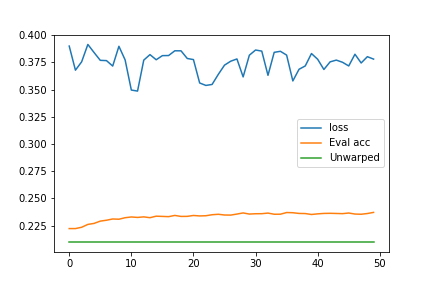

In [11]:
%matplotlib notebook  
eval_mean_dice, unwarped_dice = evaluate_model(student)
print(eval_mean_dice)
print(unwarped_dice)
plt.plot(np.arange(len(losses)), losses, label='loss')
plt.plot(np.arange(len(accs)), accs, label='Eval acc')
plt.plot(np.arange(len(unwarped)), unwarped, label='Unwarped')
plt.legend()

now = datetime.datetime.now().strftime("%d_%m_%y-%H-%M")
plt.savefig(f'plots/pwc_teacher_{now}.png')

In [12]:
update_sheet(epochs, optimizer, 'SoftTarget PWC + diffloss',grad_accum,lr, mode, eval_mean_dice.item(), unwarped_dice, "One Hot for MSE + Scale_Factr=1*64 + dataset3")

updated


In [13]:
torch.save(student.state_dict(), f"models/Experiment_2/obel16_pwc_soft_teacher_{now}.pth")

tensor([0.7675, 0.7925]) VS unwarped tensor([0.6713, 0.7197])


<IPython.core.display.Javascript object>


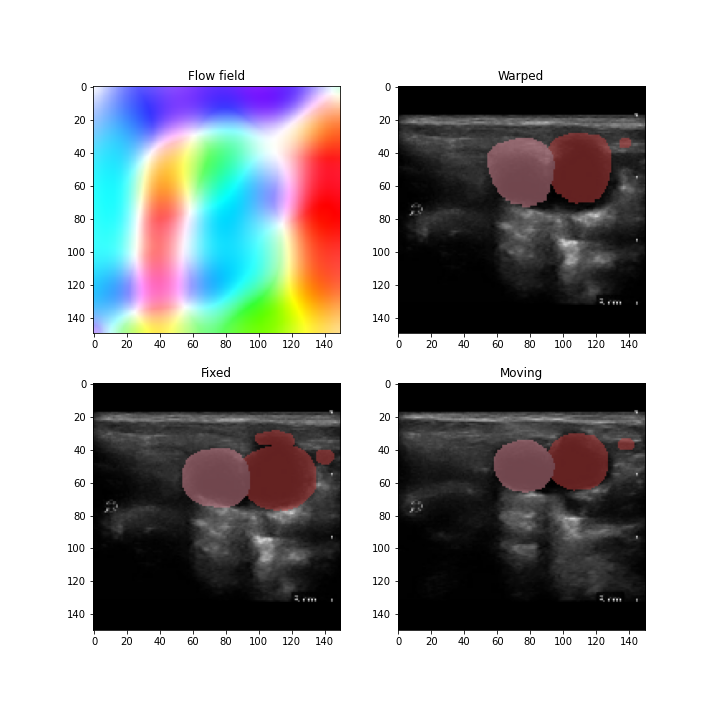

In [24]:
student.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]

fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous()
moving_seg = segs[p_fix:p_fix+1,1,:].contiguous()

# quick fix here...
if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
    fixed_seg = fixed_seg*2
if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
    moving_seg = moving_seg*2


with torch.no_grad():
    fixed_feat = student(fixed.cuda())
    moving_feat = student(moving.cuda())

ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')

#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

#warped_teacher_seg = warp(moving_seg.unsqueeze(0).float().cuda(),teacher_flow.squeeze().cuda()).cpu()

d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),3)
d0 = dice_coeff(fixed_seg,moving_seg,3)

print(f"{d1} VS unwarped {d0}")

rgb = showFlow(dense_flow_fit.cpu().transpose(-2,-1))
overlay = overlaySegment(fixed.squeeze(),warped_student_seg.data.squeeze(),False)

overlay_fixed = overlaySegment(fixed.squeeze(),fixed_seg.data.squeeze(),False)
overlay_moving = overlaySegment(moving.squeeze(),moving_seg.data.squeeze(),False)

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(rgb)
plt.title("Flow field")
plt.subplot(222)
plt.imshow(overlay)
plt.title("Warped")

plt.subplot(223)
plt.imshow(overlay_fixed)
plt.title('Fixed')
plt.subplot(224)
plt.imshow(overlay_moving)
plt.title("Moving")
plt.show()

# Training with Ensemble

In [7]:
disp_hw = 5
displace_range = 11
label_weights = torch.tensor([0.1,0.6, 0.3])# weights for background = 0.1, Vein = 0.6 and Artery = 0.3
epochs = 100
lr = 0.00025
grad_accum = 5

H=150;W=150

student = OBELISK2d(16)
init_weights(student)
student.train().cuda()

optimizer = torch.optim.Adam(list(student.parameters()),lr=lr, weight_decay=0.00005)
alpha=0.5

In [ ]:
losses = []
accs = []
unwarped = []
scale=2
for epoch in trange(epochs):

    # Cross Validation
    train_set = torch.from_numpy(np.random.choice(np.arange(len(imgs)),size=int(len(imgs)*0.95), replace=False))

    test_set = torch.arange(len(imgs))
    for idx in train_set:
        test_set = test_set[test_set != idx]
    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for i, rnd_idx in enumerate(rnd_train_idx):
        tmp_loss = []
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous() * 2
        moving_seg = segs[p_fix:p_fix+1,1,:].contiguous() * 2

        if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
            fixed_seg = fixed_seg*2
        if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
            moving_seg = moving_seg*2
        ########## PWC-Net
        # Here we rescale the images for the Teacher 
        # the flownet expects intputs that match Nx64. 
        teacher_fixed = F.interpolate(fixed, size=(scale*64,scale*64), mode='bicubic')
        teacher_moving = F.interpolate(moving, size=(scale*64,scale*64), mode='bicubic')

        # Generate the pwc flow estimation
        pwc_flow_in = preprocessing_pwc(teacher_fixed.detach().clone().reshape(scale*64,scale*64,1),teacher_moving.detach().clone().reshape(scale*64,scale*64,1)).cuda()
        pwc_flow = pwc(pwc_flow_in) 
        pwc_flow = F.interpolate(pwc_flow, size=(H,W),mode='bicubic')

        # warp the segmentations with pwc flow
        warped_pwc_seg = warp(moving_seg.float().unsqueeze(0).cuda(), pwc_flow.cuda()).cpu()
        #print(dice_coeff(warped_pwc_seg, fixed_seg, 3))
         ########## FlowNet2
        # Generate the flownet flow estimation
        flow_in = preprocessing_flownet(teacher_fixed.detach().clone().reshape(scale*64,scale*64,1),teacher_moving.detach().clone().reshape(scale*64,scale*64,1)).cuda() * 255
        flownet_flow = flownet(flow_in)
        flownet_flow = F.interpolate(flownet_flow.cpu(), size=(H,W), mode='bicubic')

        # warp segmentation with flownet flow
        warped_flownet_seg = warp(moving_seg.float().unsqueeze(0).cuda(), flownet_flow.cuda()).cpu()
        

        # Label preparation for PDD
        C1,Hf,Wf = moving_seg.size()
        label_moving_onehot = F.one_hot(moving_seg.long(),num_classes=3).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving_onehot,size=(Hf//4 +1,Wf//4 +1),mode='bicubic')
        label_fixed = F.one_hot(fixed_seg.long(),num_classes=3).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed,size=(Hf//4 +1,Wf//4 +1),mode='bicubic')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,3,displace_range**2,-1)

        #with torch.cuda.amp.autocast():
        ########## PDD Forward pass
        soft_cost,disp_xy = student(fixed.cuda(), moving.cuda())
        #feat50 = student(moving.cuda())

        # compute the cost tensor using the correlation layer
        #ssd_distance = correlation_layer(displace_range, feat50, feat00)

        # compute the MIN-convolution & probabilistic output with the given function
        #soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4 +1, W//4 +1)

        # warp the label
        label_warped = torch.sum(soft_cost.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
        
        
        #dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')
        #apply and evaluate transformation
        #identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
        #warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu() 
        
        pwc_onehot = labelMatrixOneHot(F.interpolate(warped_pwc_seg, size=(H//4 +1, W//4 +1), mode='bicubic').view(1,H//4 +1, W//4 +1), 3)
        flownet_onehot = labelMatrixOneHot(F.interpolate(warped_flownet_seg, size=(H//4 +1, W//4 +1), mode='bicubic').view(1,H//4 +1, W//4 +1), 3)

        pwc_diff = torch.sum(torch.pow(label_warped.view(3,-1)-pwc_onehot.view(3,-1).detach(),2), 1)
        flownet_diff = torch.sum(torch.pow(label_warped.view(3,-1)-flownet_onehot.view(label_warped.shape),2), 1)

        label_distance1 = torch.sum(torch.pow(label_fixed.reshape(3,-1)-label_warped.reshape(3,-1),2),1) * label_weights

        diffloss = 2*((disp_xy[0,:,1:,:]-disp_xy[0,:,:-1,:])**2).mean()+\
            2*((disp_xy[0,1:,:,:]-disp_xy[0,:-1,:,:])**2).mean()+\
            2*((disp_xy[0,:,:,1:]-disp_xy[0,:,:,:-1])**2).mean()
        
        
        # Caclculate the label weighted teacher loss
        teacher_loss = (alpha * pwc_diff + (1-alpha)*flownet_diff) * label_weights
        
        # Combine the teacherloss with the label loss
        loss = teacher_loss.mean() #+ label_distance1.mean() + diffloss
        
        # propagate backwards
        loss.backward()
        tmp_loss.append([teacher_loss.mean().item(),
                        diffloss.item(),
                        label_distance1.mean().item(), 
                        loss.item()])
        
        if i %grad_accum == 0:
            # every grad_accum iterations :Make an optimizer step
            optimizer.step()
            optimizer.zero_grad()

    losses.append(np.mean(tmp_loss, axis=0))
    print(np.mean(tmp_loss, axis=0))
    #eval_dice, unw = evaluate_model(student)
    #accs.append(eval_dice)
    #print(np.mean(tmp_loss, axis=0))
    #unwarped.append(unw)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
now = datetime.datetime.now().strftime("%d_%m_%y-%H-%M")
torch.save(student.state_dict(), f"models/Experiment_2/obel_16_soft_WL_{now}.pth")

In [ ]:
plt.plot(np.arange(len(losses)), np.array(losses)[:,0], label='Combined Teacher Loss', alpha=alpha)
plt.plot(np.arange(len(losses)), np.array(losses)[:,2], label='Label Loss', alpha=alpha)
plt.plot(np.arange(len(losses)), np.array(losses)[:,3], label='Overall Loss', alpha=alpha)
#plt.plot(np.arange(len(losses)), np.array(losses)[:,4], label='Overall Loss')
plt.legend()
plt.savefig(f"plots/KD_soft-100_{now}.png")

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

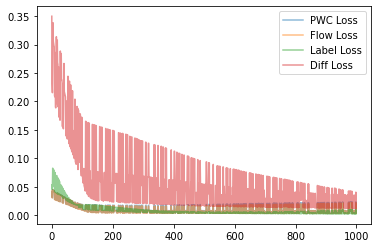

In [45]:
plt.plot(np.arange(len(losses)), np.array(losses)[:,0], label='PWC Loss', alpha=alpha)
plt.plot(np.arange(len(losses)), np.array(losses)[:,1], label='Flow Loss', alpha=alpha)
plt.plot(np.arange(len(losses)), np.array(losses)[:,2], label='Label Loss', alpha=alpha)
plt.plot(np.arange(len(losses)), np.array(losses)[:,3], label='Diff Loss', alpha=alpha)
#plt.plot(np.arange(len(losses)), np.array(losses)[:,4], label='Overall Loss')
plt.legend()

In [ ]:
now = datetime.datetime.now().strftime("%d_%m_%y-%H-%M")
torch.save(student.state_dict(), f"models/Experiment_2/obel_16_kd_{now}.pth")

In [ ]:
plt.plot(np.arange(len(losses)), losses, label='loss')
plt.plot(np.arange(len(accs)), accs, label='Eval acc')
plt.plot(np.arange(len(unwarped)), unwarped, label='Unwarped')
plt.legend()

now = datetime.datetime.now().strftime("%d_%m_%y-%H-%M")
#plt.savefig(f'plots/ensemble_teacher_soft_{now}.png')

In [ ]:
update_sheet(epochs, optimizer, 'Ensemble + diffloss+ Label',grad_accum,lr, mode, eval_mean_dice.item(), unwarped_dice, "One Hot for KLDiv + Scale_Factr=1*64 + alpha=0.5 + dataset3")

In [ ]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

# !!ALL BELOW DID NOT WORK!!

# Experiment 2.2
Using MSE loss between the flow predictions. 

In [15]:
student = OBELISK2d(24)
init_weights(student)
student.train().cuda()

optimizer = torch.optim.Adam(list(student.parameters()),lr=lr)

In [16]:
for epoch in tqdm(range(epochs)):

    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for rnd_idx in rnd_train_idx:
        
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
        moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()

        # Here we have to rescale the images for the flownet
        # the flownet expects intputs that match x*64, when m and n < 200
        teacher_fixed = F.interpolate(fixed, size=(128,128))
        teacher_moving = F.interpolate(moving, size=(128,128))
        # Generate the teacher flow estimation
        flow_in = preprocessing_flownet(teacher_fixed.detach().clone().reshape(128,128,1),teacher_moving.detach().clone().reshape(128,128,1)).cuda()
        teacher_flow = flownet(flow_in)
        teacher_flow = F.interpolate(teacher_flow, size=(H//4,W//4), mode='bilinear')
        
        # Label preparation
        #C1,Hf,Wf = moving_seg.size()
        #label_moving_onehot = F.one_hot(moving_seg,num_classes=3).permute(0,3,1,2).float()
        #label_moving = F.interpolate(label_moving_onehot,size=(Hf//4,Wf//4),mode='bilinear')
        #label_fixed_onehot = F.one_hot(fixed_seg,num_classes=3).permute(0,3,1,2).float()
        #label_fixed = F.interpolate(label_fixed_onehot,size=(Hf//4,Wf//4),mode='bilinear')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        #label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,3,displace_range**2,-1)

        feat00 = student(fixed.cuda())
        feat50 = student(moving.cuda())

        # compute the cost tensor using the correlation layer
        ssd_distance = correlation_layer(displace_range, feat50, feat00)

        # compute the MIN-convolution & probabilistic output with the given function
        soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
        
        #loss = cross_entropy_loss(disp_xy,teacher_flow)
        loss = torch.sum(torch.pow(disp_xy - teacher_flow, 2))
        loss.backward()
        if (epoch+1)%grad_accum == 0:
            # every grad_accum iterations :Make an optimizer step
            optimizer.step()
            optimizer.zero_grad()

100%|██████████| 100/100 [1:34:52<00:00, 56.93s/it]


In [17]:
evaluate_model(student)

This model has an average Dice of 0.33651 mit Variance: 0.02122. The unwarped Mean dice is: 0.32494 with Var 0.0243


In [18]:
torch.save(student.state_dict(), "models/obel_MSE_teacher_flow.pth")

# Experiment 2.3
Using warped label loss as simple addition to the MSE loss

In [19]:
student = OBELISK2d(24)
init_weights(student)
student.train().cuda()

optimizer = torch.optim.Adam(list(student.parameters()),lr=lr)

In [20]:
for epoch in tqdm(range(epochs)):

    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for rnd_idx in rnd_train_idx:
        
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
        moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()

        # Here we have to rescale the images for the flownet
        # the flownet expects intputs that match x*64, when m and n < 200
        teacher_fixed = F.interpolate(fixed, size=(128,128))
        teacher_moving = F.interpolate(moving, size=(128,128))
        # Generate the teacher flow estimation
        flow_in = preprocessing_flownet(teacher_fixed.detach().clone().reshape(128,128,1),teacher_moving.detach().clone().reshape(128,128,1)).cuda()
        teacher_flow = flownet(flow_in)
        teacher_flow = F.interpolate(teacher_flow, size=(H//4,W//4), mode='bilinear')
        
        # Label preparation
        C1,Hf,Wf = moving_seg.size()
        label_moving_onehot = F.one_hot(moving_seg,num_classes=3).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving_onehot,size=(Hf//4,Wf//4),mode='bilinear')
        label_fixed_onehot = F.one_hot(fixed_seg,num_classes=3).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed_onehot,size=(Hf//4,Wf//4),mode='bilinear')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,3,displace_range**2,-1)

        feat00 = student(fixed.cuda())
        feat50 = student(moving.cuda())

        # compute the cost tensor using the correlation layer
        ssd_distance = correlation_layer(displace_range, feat50, feat00)

        # compute the MIN-convolution & probabilistic output with the given function
        soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
        
        # warp the label
        label_warped = torch.sum(soft_cost.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
        # warp segment with teacher flow
        warped_teacher_seg = warp_seg(label_moving.squeeze().float().cuda(),teacher_flow.cuda()).cpu()
        
        teacher_loss = torch.sum(torch.pow(disp_xy - teacher_flow, 2))
        label_distance1 = torch.sum(torch.pow(label_fixed.reshape(3,-1)-label_warped.reshape(3,-1),2),0)
        loss = teacher_loss + label_distance1.mean()
        if (epoch+1)%grad_accum == 0:
            # every grad_accum iterations :Make an optimizer step
            optimizer.step()
            optimizer.zero_grad()

100%|██████████| 100/100 [48:20<00:00, 29.00s/it]


In [21]:
evaluate_model(student)

This model has an average Dice of 0.30596 mit Variance: 0.02538. The unwarped Mean dice is: 0.32494 with Var 0.0243


In [22]:
torch.save(student.state_dict(), "models/obel_MSE_warped.pth")

# Experiment 2.4
Using the weighted label loss

In [10]:
student = OBELISK2d(24)
init_weights(student)
student.train().cuda()

optimizer = torch.optim.Adam(list(student.parameters()),lr=lr)

In [11]:
for epoch in tqdm(range(epochs)):

    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for rnd_idx in rnd_train_idx:
        
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
        moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()

        # Here we have to rescale the images for the flownet
        # the flownet expects intputs that match x*64, when m and n < 200
        teacher_fixed = F.interpolate(fixed, size=(128,128))
        teacher_moving = F.interpolate(moving, size=(128,128))
        # Generate the teacher flow estimation
        flow_in = preprocessing_flownet(teacher_fixed.detach().clone().reshape(128,128,1),teacher_moving.detach().clone().reshape(128,128,1)).cuda()
        teacher_flow = flownet(flow_in)
        teacher_flow = F.interpolate(teacher_flow, size=(H//4,W//4), mode='bilinear')
        
        # Label preparation
        C1,Hf,Wf = moving_seg.size()
        label_moving_onehot = F.one_hot(moving_seg,num_classes=3).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving_onehot,size=(Hf//4,Wf//4),mode='bilinear')
        label_fixed_onehot = F.one_hot(fixed_seg,num_classes=3).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed_onehot,size=(Hf//4,Wf//4),mode='bilinear')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,3,displace_range**2,-1)

        feat00 = student(fixed.cuda())
        feat50 = student(moving.cuda())

        # compute the cost tensor using the correlation layer
        ssd_distance = correlation_layer(displace_range, feat50, feat00)

        # compute the MIN-convolution & probabilistic output with the given function
        soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
        
        # warp the label
        label_warped = torch.sum(soft_cost.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
        # warp segment with teacher flow
        warped_teacher_seg = warp_seg(moving_seg.float().cuda(),F.interpolate(teacher_flow, size=(H,W), mode='bilinear').cuda()).cpu()
        
        # calculate losses
        teacher_loss = torch.sum(torch.pow(disp_xy - teacher_flow, 2))
        label_distance1 = torch.sum(torch.pow(label_fixed.reshape(3,-1)-label_warped.reshape(3,-1),2),0)
        
        # calculate the dice score for the warped segmentation
        d0 = dice_coeff(warped_teacher_seg.squeeze(), fixed_seg.unsqueeze(0).float(), 3)
        
        # The loss can then be weighted
        loss = (d0.mean().item()) * teacher_loss + (1- d0.mean().item()) * label_distance1.mean()
        if (epoch+1)%grad_accum == 0:
            # every grad_accum iterations :Make an optimizer step
            optimizer.step()
            optimizer.zero_grad()

100%|██████████| 100/100 [50:04<00:00, 30.05s/it]


In [12]:
evaluate_model(student)

This model has an average Dice of 0.28963 mit Variance: 0.02797. The unwarped Mean dice is: 0.33263 with Var 0.02592


In [13]:
torch.save(student.state_dict(), "models/obel_MSE_weighted_warped.pth")

In [14]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}